# Sampling techniques: rejection vs Metropolis

How to sample according to a given positive and integrable function, i.e. a density function with an unknown constant of normalization?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, rv_continuous, uniform
from statsmodels.tsa.stattools import acovf

In [2]:
def f_to_sample(x):
    xmin, xmax = 0, 5
    return np.where((xmin <= x) & (x <= xmax), 1.5*np.exp(-np.abs(x-4)) + (x**1*(5-x)**8)/10e4, 0)

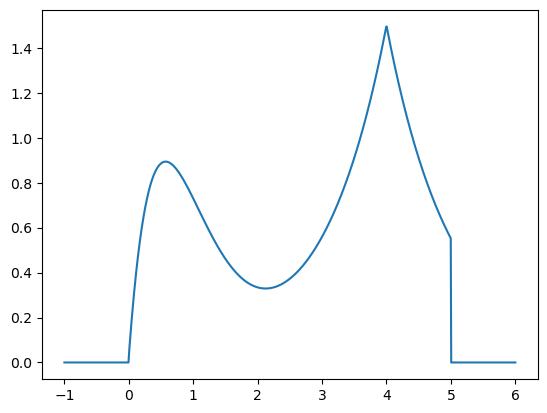

In [3]:
x = np.linspace(-1, 6, 1000)

plt.plot(x, f_to_sample(x))
plt.show()

## 1. Rejection sampling

In [4]:
import numpy as np
from scipy.stats import rv_continuous


def sample_reject(f: callable, g: rv_continuous, c: float, n_samples: int, verbose: bool = False) -> np.ndarray:
    """
    Generate samples from a target distribution using rejection sampling.

    Parameters:
        f (callable): The target distribution to sample from (not normalized).
        g (scipy.stats.rv_continuous): A continuous random variable object representing
            the proposal distribution.
        c (float): Constant multiplier for the proposal distribution.
        n_samples (int): Number of samples to generate.
        verbose (bool, optional): If True, prints the percentage of rejected samples.

    Returns:
        numpy.ndarray: Array containing the generated samples.

    Raises:
        ValueError: If `c` is not large enough to cover the target distribution adequately.
    """
    ret = []
    k = 0
    while len(ret) < n_samples:
        s = g.rvs()
        r = f(s) / (c * g.pdf(s))
        if r > 1:
            raise ValueError("`c` is not large enough !")
        else:
            if np.random.uniform() <= r:
                ret.append(s)
        k += 1
    if verbose:
        print(f"{100*(k-n_samples)/k:.2f}% of samples were rejected")
    return np.array(ret)

56.08% of samples were rejected
CPU times: total: 2.66 s
Wall time: 5.09 s


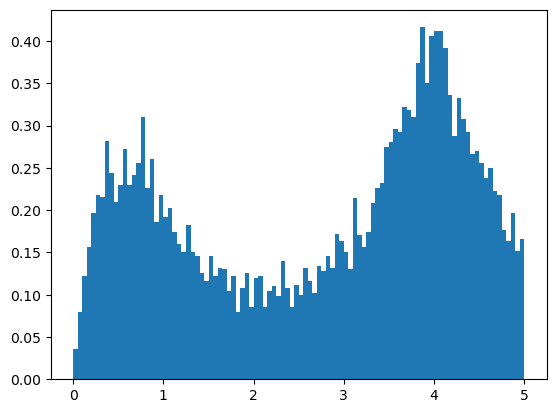

In [5]:
%time samples = sample_reject(f=f_to_sample, g=uniform(0, 5), c=8, n_samples=10000, verbose=True)

n_bins = 100

plt.hist(samples, bins=n_bins, density=True)
plt.show()

Are the drawn samples correlated ? No, they are not.

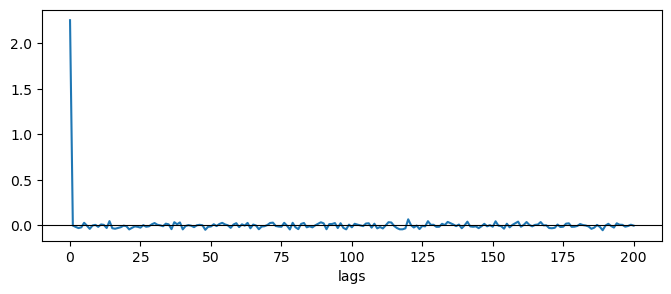

In [6]:
plt.figure(figsize=(8, 3))
plt.plot(acovf(samples, nlag=200))
plt.axhline(y=0, c='k', lw=0.8)
plt.xlabel('lags')
plt.show()

## 2. Metropolis sampling

In [7]:
def metropolis(f: callable, x0: float, proposal_generator: rv_continuous, n_samples: int) -> np.ndarray:
    """
    Perform Metropolis-Hastings sampling to generate samples from a target distribution.

    Parameters:
        f (callable): The target distribution to sample from.
        x0 (float): Initial state for the Markov chain.
        proposal_generator (scipy.stats.rv_continuous): A continuous random variable object
            from scipy.stats representing the proposal distribution.
        n_samples (int): Number of samples to generate.

    Returns:
        numpy.ndarray: Array containing the generated samples.
    """
    ret = np.empty(n_samples + 1)
    current_state = x0
    for i in range(n_samples):
        proposed_state = current_state + proposal_generator.rvs()
        acceptance_ratio = min(1, f(proposed_state) / f(current_state))
        if np.random.uniform() <= acceptance_ratio:
            current_state = proposed_state
        ret[i] = current_state
    return ret

CPU times: total: 438 ms
Wall time: 785 ms


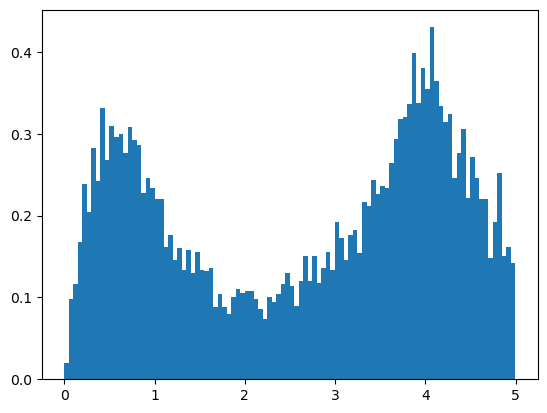

In [8]:
%time samples = metropolis(f=f_to_sample, x0=2.5, proposal_generator=norm(0, 0.5), n_samples=10000)

plt.hist(samples, bins=n_bins, density=True)
plt.show()

The Metropolis algorithm implies possibly "staying" at the same spot in some iterations. One can compute the percentage of unique values among the drawn samples:

In [9]:
100*len(np.unique(samples)) / len(samples)

80.1019898010199

Are the samples drawn correlated ? Yes they are.

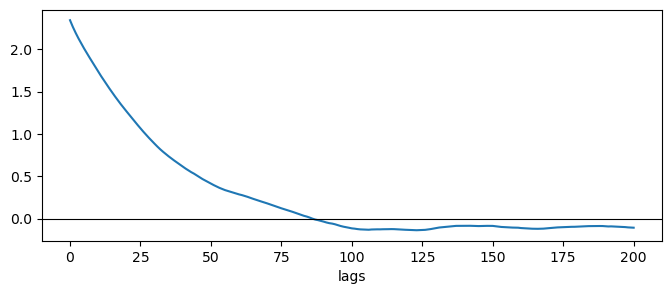

In [10]:
plt.figure(figsize=(8, 3))
plt.plot(acovf(samples, nlag=200))
plt.axhline(y=0, c='k', lw=0.8)
plt.xlabel('lags')
plt.show()